In [1]:
import itertools
import os
import shutil
import sqlite3
from datetime import datetime, timedelta

In [2]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from pandas.core.frame import DataFrame
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [3]:
DATE_FORMAT = "%Y-%m-%d %H:%M:%S"

CONFIG

In [4]:
plt.style.use("fivethirtyeight")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [5]:
BEST_KMEANS_CLUSTERS_NUMBER = 3

In [6]:
kmeans_kwargs = {
    "init": "k-means++",
    "n_init": 50,
    "max_iter": 500,
    "random_state": 42
}

In [7]:
all_payment_types_one_hot_columns = [
    "payment_type_boleto",
    "payment_type_credit_card",
    "payment_type_voucher",
    "payment_type_credit_card_with_voucher",
    "payment_type_debit_card",
    "payment_type_multiple"
]

In [8]:
def load_data(overall_earliest_purchase_date, week_numbers):
    """Load the data from the db, extract the RFM and average review attributes and returns them."""
    con = sqlite3.connect("resources/olist.db")
    con.row_factory = sqlite3.Row
    cur = con.cursor()
    
    res = cur.execute("""SELECT customer_id, customer_unique_id FROM customers
    where customer_id in (select customer_id from orders)""")
    customers = res.fetchall()
    
    res = cur.execute("select order_id, review_score from order_reviews")
    reviews = res.fetchall()
    
    res = cur.execute(
        """SELECT o.order_id, o.customer_id, o.order_purchase_timestamp, oi.price
    FROM orders o
    inner join order_items oi on o.order_id = oi.order_id""")
    orders = res.fetchall()
    
    res = cur.execute(
        "select order_id, payment_type from order_pymts where payment_type != 'not_defined'")
    payments = res.fetchall()
    
    cur.close()
    con.close()
    
    sorted_reviews = {}
    for review in reviews:
        sorted_reviews.setdefault(
            review['order_id'],
            []).append(
            review['review_score'])
        
    sorted_payments = {}
    for payment in payments:
        sorted_payments.setdefault(
            payment['order_id'],
            set()).add(
            payment['payment_type'])
        
    sorted_orders = {}
    max_purchase_date = overall_earliest_purchase_date + \
        timedelta(weeks=week_numbers)
    for order in [dict(order) for order in orders]:
        order_id = order['order_id']
        
        order['review_score'] = sorted_reviews[order_id][0] if order['order_id'] in sorted_reviews else None
        
        purchase_date = datetime.strptime(
            order['order_purchase_timestamp'], DATE_FORMAT)
        if purchase_date > max_purchase_date:
            continue
            
        if order_id in sorted_payments and len(sorted_payments[order_id]) > 1:
            if 'voucher' in sorted_payments[order_id]:
                sorted_payments[order_id].remove('voucher')
                payment_type = sorted_payments[order_id].pop()
                sorted_payments[order_id].add(payment_type + "_with_voucher")
            # only 1 case with debit_card + credit_card, I'm skipping it
            else:
                continue
        elif order_id not in sorted_payments:
            continue
            
        order['payment_type'] = sorted_payments[order_id] if order['order_id'] in sorted_payments else None
        
        sorted_orders.setdefault(order['customer_id'], []).append(order)
        
    sorted_customers = {}
    for customer in [dict(customer) for customer in customers]:
        sorted_customers.setdefault(
            customer['customer_unique_id'], []).append(
            customer['customer_id'])
        
    clients = []
    for customer_unique_id in sorted_customers.keys():
        customer_ids = sorted_customers[customer_unique_id]
        
        customer_orders = []
        for customer_id in customer_ids:
            customer_orders += sorted_orders[customer_id] if customer_id in sorted_orders else []
        if len(customer_orders) == 0:
            continue
            
        total_amount = sum([order['price'] for order in customer_orders])
        
        nb_products = len(customer_orders)
        
        order_timestamps = [
            datetime.strptime(
                order['order_purchase_timestamp'],
                DATE_FORMAT) for order in customer_orders]
        earliest_purchase_date: datetime = min(order_timestamps)
        days_since_first_purchase = (
            datetime.now() - earliest_purchase_date).days
        
        review_scores = [order['review_score']
                         for order in customer_orders if order['review_score'] is not None]
        if len(review_scores) > 0:
            average_review = sum(review_scores) / len(review_scores)
        else:
            average_review = 0
            
        payment_types = set(list(itertools.chain.from_iterable(
            [list(order['payment_type']) for order in customer_orders])
        ))
        if len(payment_types) == 1:
            payment_type = list(payment_types)[0]
        else:
            payment_type = "multiple"

        # Excludes 71 clients for a better visibility of the clusters
        if nb_products < 8:
            clients.append({
                'average_review': average_review,
                'days_since_first_purchase': days_since_first_purchase,
                'frequency': nb_products,
                'monetary_value': total_amount,
                "payment_type": payment_type
            })
            
    return clients

In [9]:
def prepare_data(df):
    """Prepare data for the Kmeans clustering model."""
    one_hot_encoder = OneHotEncoder(
        handle_unknown="ignore",
        sparse_output=False)
    
    payment_type_df = one_hot_encoder.fit_transform(df[["payment_type"]])
    payment_type_df = DataFrame(
        payment_type_df,
        columns=one_hot_encoder.get_feature_names_out())
    payment_type_df.index = df.index
    
    df.drop("payment_type", axis=1, inplace=True)
    
    scaled_df = DataFrame(
        StandardScaler().fit_transform(df),
        columns=df.columns)
    
    encoded_df = pd.concat([scaled_df, payment_type_df], axis=1)
    
    for missing_column in [
            col for col in all_payment_types_one_hot_columns if col not in df.columns]:
        encoded_df[missing_column] = 0
        
    encoded_df = encoded_df.reindex(sorted(df.columns), axis=1)
    return encoded_df

In [10]:
def get_kmeans_model_fit_on_clients(clients):
    """Fit a Kmeans model with the best number of clusters on the given clients and returns it."""
    prepared_df = prepare_data(DataFrame(clients))
    
    model = KMeans(n_clusters=BEST_KMEANS_CLUSTERS_NUMBER, **kmeans_kwargs)
    model.fit(prepared_df)
    
    return model

In [11]:
def create_ari_scores_plot(ari_results):
    """Generate and display a plot showing the ARI scores by week number."""
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 12)
    
    plot = sns.lineplot(
        DataFrame(ari_results),
        x="weeks_number",
        y="ari_score",
        ax=ax)
    
    plot.set_title("ARI score per weeks")
    plot.set_xlabel("Weeks number")
    plot.set_ylabel("ARI score")
    # ax.hlines(
    #     y=0.7,
    #     xmin=1,
    #     xmax=max_weeks_number,
    #     color='black',
    #     linestyles='dashdot')

    # fig.savefig(f"simulation_plots/ari_scores.png")
    
    plt.show()
    plt.close()

In [12]:
def perform_simulation(
        overall_earliest_purchase_date,
        overall_week_numbers,
        first_period_week_numbers):
    """Performs the simulation comparing the results of a model trained on a fixed period A and a model trained on a growing period B that includes the period A."""
    initial_period_clients: list[dict] = load_data(
        overall_earliest_purchase_date, first_period_week_numbers)
    print(f"Initial period clients:{len(initial_period_clients)}.\n")
    
    initial_period_model = get_kmeans_model_fit_on_clients(
        initial_period_clients)
    
    ari_results = []
    for weeks_number in range(
            first_period_week_numbers + 1,
            overall_week_numbers):
        considered_period_clients = load_data(
            overall_earliest_purchase_date, weeks_number)
        
        considered_period_model = get_kmeans_model_fit_on_clients(
            considered_period_clients)
        considered_period_labels = considered_period_model.labels_
        
        initial_model_labels = initial_period_model.predict(
            prepare_data(DataFrame(considered_period_clients)))
        
        ari_score = round(
            adjusted_rand_score(
                initial_model_labels,
                considered_period_labels),
            4)
        ari_results.append(
            {'weeks_number': weeks_number, 'ari_score': ari_score})
        
        print(
            f"ARI score:{
                round(
                    ari_score,
                    2)} for {
                len(considered_period_clients)} clients in week number:{weeks_number}.")
        
    create_ari_scores_plot(ari_results)

In [13]:
def get_earliest_and_latest_purchase_dates():
    """Returns the earliest and latest purchase dates from the dataset."""
    con = sqlite3.connect("resources/olist.db")
    con.row_factory = sqlite3.Row
    cur = con.cursor()
    
    cur.execute("""select distinct order_purchase_timestamp from orders""")
    purchase_dates = cur.fetchall()
    
    cur.close()
    con.close()
    
    parsed_purchase_dates = [
        datetime.strptime(
            order['order_purchase_timestamp'],
            DATE_FORMAT) for order in purchase_dates]
    
    return min(parsed_purchase_dates), max(parsed_purchase_dates)

In [14]:
def get_week_number_when_first_period_includes_half_of_clients(
    overall_earliest_purchase_date, overall_week_numbers):
    """Returns the week number defining the end period from the earliest purchase date containing at least half of all clients based on their earliest purchase.""" 
    for week_number in range(1, overall_week_numbers):
        days_since_first_period_start = (datetime.now() - overall_earliest_purchase_date).days
        days_since_first_period_end = days_since_first_period_start - week_number * 7
    
        all_clients = load_data(overall_earliest_purchase_date, 999)
        
        first_period_clients = [client for client in all_clients
                                if days_since_first_period_end < client['days_since_first_purchase']
                                <= days_since_first_period_start]
        
        share_of_clients_in_first_period = round(
            len(first_period_clients) / len(all_clients), 2)
        
        if share_of_clients_in_first_period > 0.5:
            print(
                f"The first period includes {
                    share_of_clients_in_first_period *
                    100}% of the clients " f"in week number:{week_number}.\n")
            
            return week_number

Starting simulation script.

Earliest purchase date:2016-09-04 21:15:19, latest purchase date:2018-10-17 17:30:18, overall_week_numbers:110.

The first period includes 52.0% of the clients in week number:73.

Starting simulation.

Initial period clients:49718.

ARI score:1.0 for 51235 clients in week number:74.
ARI score:1.0 for 52767 clients in week number:75.
ARI score:1.0 for 54320 clients in week number:76.
ARI score:1.0 for 55999 clients in week number:77.
ARI score:1.0 for 57792 clients in week number:78.
ARI score:1.0 for 59382 clients in week number:79.
ARI score:0.92 for 60920 clients in week number:80.
ARI score:0.92 for 62583 clients in week number:81.
ARI score:1.0 for 63994 clients in week number:82.
ARI score:1.0 for 65530 clients in week number:83.
ARI score:1.0 for 67011 clients in week number:84.
ARI score:1.0 for 68640 clients in week number:85.
ARI score:1.0 for 70269 clients in week number:86.
ARI score:1.0 for 71967 clients in week number:87.
ARI score:1.0 for 7386

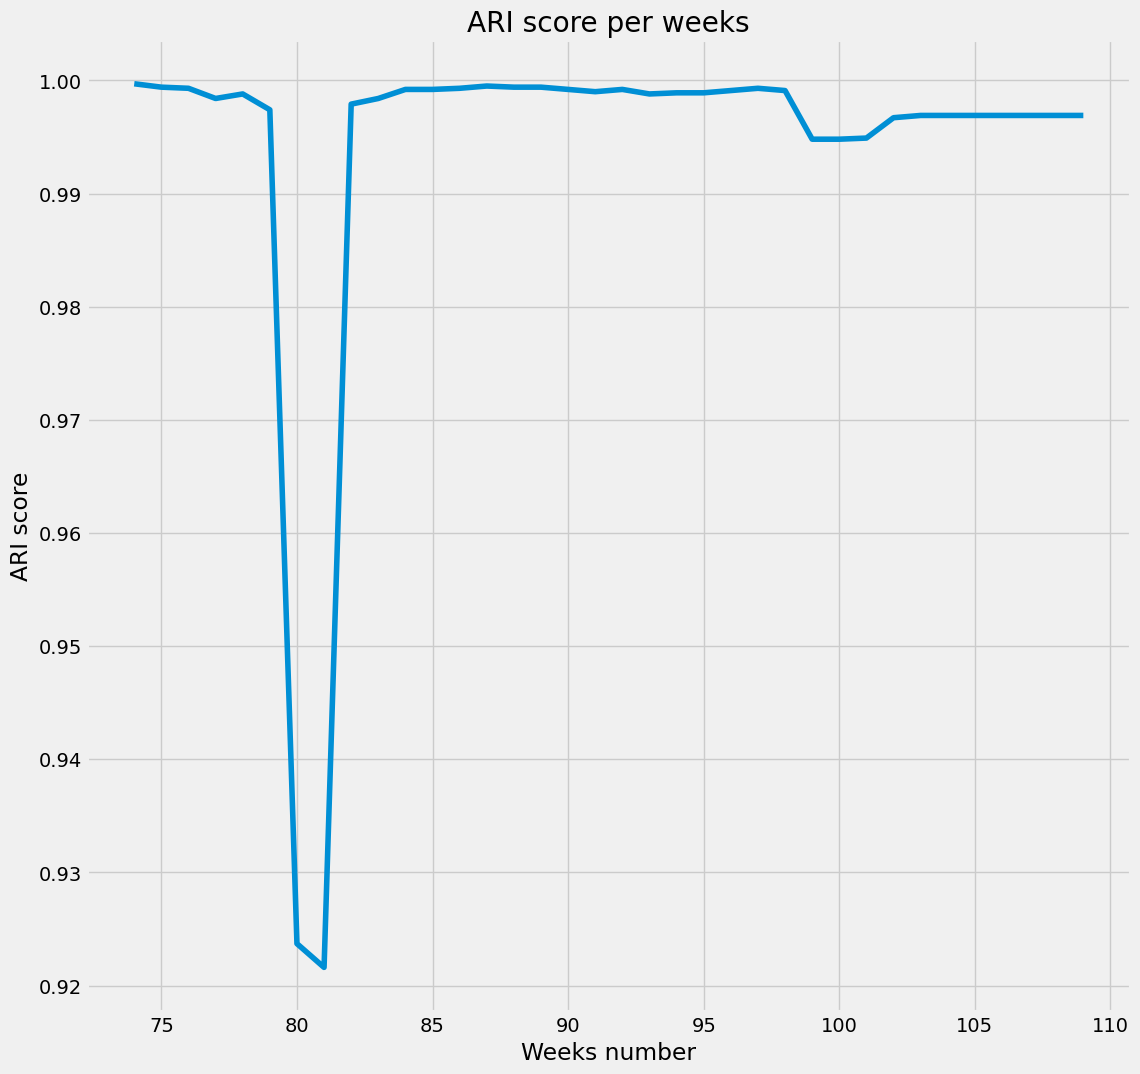


The simulation is now done.


In [15]:
print("Starting simulation script.\n")

overall_earliest_purchase_date, overall_latest_purchase_date = get_earliest_and_latest_purchase_dates()
overall_week_numbers = (
    overall_latest_purchase_date - overall_earliest_purchase_date).days // 7

print(f"Earliest purchase date:{overall_earliest_purchase_date}, "
      f"latest purchase date:{overall_latest_purchase_date}, "
      f"overall_week_numbers:{overall_week_numbers}.\n")

first_period_week_numbers = get_week_number_when_first_period_includes_half_of_clients(
    overall_earliest_purchase_date, overall_week_numbers)

print("Starting simulation.\n")
perform_simulation(
    overall_earliest_purchase_date,
    overall_week_numbers,
    first_period_week_numbers)

print("\nThe simulation is now done.")